# CAPSTONE PROJECT 1: ML PIPELINE

###### SUBMITTED BY: GARGI S

### INITIALISING SPARK AND IMPORTING LIBRARIES

In [1]:
import os
os.environ['PYSPARK_DRIVER_PYTHON'] = '/opt/anaconda3/bin/python3.7'
os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/bin/python3.7'
os.environ["SPARK_HOME"] = '/opt/cloudera/parcels/CDH/lib/spark'


import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession,SQLContext, Row

In [132]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassifier ,LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline

In [3]:
user_id = 'anabig114237'

In [4]:
app_name = '{0} : Hive Integration'.format(user_id)
app_name 


spark = SparkSession.builder.appName("app_name").config("spark.sql.catalogImplementation=hive").enableHiveSupport().getOrCreate() #Singleton instance

In [5]:

sparkSession = (SparkSession.builder.appName("app_name").config("hive.metastore.uris","thrift://ip-10-1-2-24.ap-south-1.compute.internal:9083").enableHiveSupport().getOrCreate())

### IMPORTING DATA

In [6]:
sparkSession.sql("use cap1g")

DataFrame[]

In [7]:
sparkSession.sql("show tables").show()

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
|   cap1g|  departments|      false|
|   cap1g|     dept_emp|      false|
|   cap1g|dept_managers|      false|
|   cap1g|    employees|      false|
|   cap1g|     salaries|      false|
|   cap1g|       titles|      false|
+--------+-------------+-----------+



In [8]:
sparkSession.sql('select c.*, a.dept_no, dept_name, salary,title, f.emp_no manager_emp_id from \
departments a inner join dept_emp b on a.dept_no = b.dept_no \
inner join employees c \
on b.emp_no = c.emp_no \
inner join salaries d \
on c.emp_no = d.emp_no \
inner join titles e \
on c.emp_title_id = e.title_id \
inner join dept_managers f \
on a.dept_no = f.dept_no' ).show(4)

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+---------+-------+-----------------+------+----------------+--------------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_|last_date|dept_no|        dept_name|salary|           title|manager_emp_id|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+---------+-------+-----------------+------+----------------+--------------+
|   d005|    "development"| 40000|Technique Leader|        110511|
|   d003|"Human Resources"| 40000|    Senior Staff|        110183|
|   d005|    "development"| 60268| Senior Engineer|        110511|
|   d007|          "Sales"| 54602|           Staff|        111035|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+---------+-------+-----------------+------+---------

In [9]:
df = sparkSession.sql('select c.*, a.dept_no, dept_name, salary,title, f.emp_no manager_emp_id from \
departments a inner join dept_emp b on a.dept_no = b.dept_no \
inner join employees c \
on b.emp_no = c.emp_no \
inner join salaries d \
on c.emp_no = d.emp_no \
inner join titles e \
on c.emp_title_id = e.title_id \
inner join dept_managers f \
on a.dept_no = f.dept_no' )

In [10]:
df.show(4)

+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+---------+-------+-----------------+------+----------------+--------------+
|emp_no|emp_title_id|birth_date|first_name|last_name|sex| hire_date|no_of_projects|last_performance_rating|left_|last_date|dept_no|        dept_name|salary|           title|manager_emp_id|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+---------+-------+-----------------+------+----------------+--------------+
|   d005|    "development"| 40000|Technique Leader|        110511|
|   d003|"Human Resources"| 40000|    Senior Staff|        110183|
|   d005|    "development"| 60268| Senior Engineer|        110511|
|   d007|          "Sales"| 54602|           Staff|        111035|
+------+------------+----------+----------+---------+---+----------+--------------+-----------------------+-----+---------+-------+-----------------+------+---------

### DATA VISUALISATION

In [12]:
data2 = df.toPandas()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


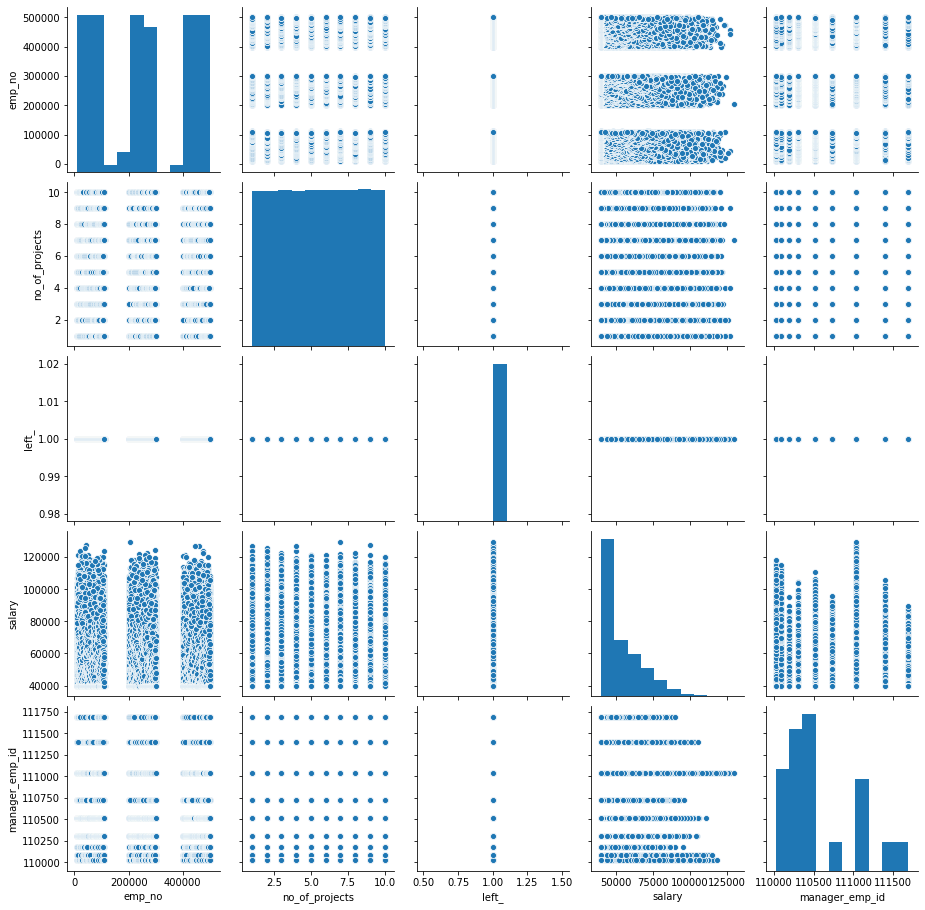

In [13]:
sns.pairplot(data= data2)

### DATA PREPARATION

In [14]:
data2

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left_,last_date,dept_no,dept_name,salary,title,manager_emp_id
0,10206,e0004,9/19/1960,Alassane,Iwayama,F,4/19/1988,8,A,True,\r,d005,"""development""",40000,Technique Leader,110511
1,10362,s0002,9/16/1963,Shalesh,dAstous,M,8/24/1988,9,B,True,\r,d003,"""Human Resources""",40000,Senior Staff,110183
2,10623,e0003,7/11/1953,Aleksander,Danlos,F,3/7/1987,2,A,True,\r,d005,"""development""",60268,Senior Engineer,110511
3,10817,s0001,10/2/1958,Uri,Rullman,F,12/26/1990,6,C,True,\r,d007,"""Sales""",54602,Staff,111035
4,11033,e0003,3/1/1957,Shushma,Bahk,F,10/2/1990,4,C,True,\r,d005,"""development""",57239,Senior Engineer,110511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300019,499411,s0002,1/18/1960,Khoa,Thambidurai,M,10/17/1985,7,B,True,\r,d003,"""Human Resources""",40000,Senior Staff,110183
300020,499480,s0001,6/7/1958,Kankanahalli,Silva,M,6/30/1993,6,B,True,\r,d007,"""Sales""",65851,Staff,111035
300021,499564,s0001,10/16/1959,Haldun,Mullainathan,M,2/26/1991,2,A,True,\r,d002,"""Finance""",46399,Staff,110085
300022,499703,s0001,7/23/1956,Goa,Nitto,M,4/11/1986,8,B,True,\r,d009,"""Customer Service""",40000,Staff,111692


In [15]:
data2['left_'].isnull().sum()

0

In [16]:
data2['last_date'].value_counts()

\r             270157
10/17/1998         15
4/23/1997\r        15
6/19/1996\r        15
11/27/1997         14
                ...  
4/3/2004\r          1
3/13/1990\r         1
3/1/1987\r          1
2/21/2011\r         1
9/17/1995\r         1
Name: last_date, Length: 7583, dtype: int64

In [17]:
#df['29'] = 
#data2['last_date'].str.strip(r'\\r')
data2['last_date'] = data2['last_date'].replace({'\r': ''})

In [18]:
data2['last_date'].value_counts()

               270157
4/23/1997\r        15
6/19/1996\r        15
10/17/1998         15
6/25/1998\r        14
                ...  
7/12/1987\r         1
6/28/1990\r         1
7/18/1988\r         1
12/16/2008          1
1/12/1990\r         1
Name: last_date, Length: 7583, dtype: int64

In [19]:
lis = []
for i in data2['last_date']:
    if i =='':
        lis.append(False)
    else:
        lis.append(True)

In [20]:
data2['left_'] = lis

In [21]:
data2['left_'].value_counts()

False    270157
True      29867
Name: left_, dtype: int64

In [22]:
data2.shape

(300024, 16)

In [23]:
data2

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date,no_of_projects,last_performance_rating,left_,last_date,dept_no,dept_name,salary,title,manager_emp_id
0,10206,e0004,9/19/1960,Alassane,Iwayama,F,4/19/1988,8,A,False,,d005,"""development""",40000,Technique Leader,110511
1,10362,s0002,9/16/1963,Shalesh,dAstous,M,8/24/1988,9,B,False,,d003,"""Human Resources""",40000,Senior Staff,110183
2,10623,e0003,7/11/1953,Aleksander,Danlos,F,3/7/1987,2,A,False,,d005,"""development""",60268,Senior Engineer,110511
3,10817,s0001,10/2/1958,Uri,Rullman,F,12/26/1990,6,C,False,,d007,"""Sales""",54602,Staff,111035
4,11033,e0003,3/1/1957,Shushma,Bahk,F,10/2/1990,4,C,False,,d005,"""development""",57239,Senior Engineer,110511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300019,499411,s0002,1/18/1960,Khoa,Thambidurai,M,10/17/1985,7,B,False,,d003,"""Human Resources""",40000,Senior Staff,110183
300020,499480,s0001,6/7/1958,Kankanahalli,Silva,M,6/30/1993,6,B,False,,d007,"""Sales""",65851,Staff,111035
300021,499564,s0001,10/16/1959,Haldun,Mullainathan,M,2/26/1991,2,A,False,,d002,"""Finance""",46399,Staff,110085
300022,499703,s0001,7/23/1956,Goa,Nitto,M,4/11/1986,8,B,False,,d009,"""Customer Service""",40000,Staff,111692


In [34]:
df1 = data2.dropna()

In [36]:
df1.shape, data2.shape

((300024, 16), (300024, 16))

In [44]:
df2 = spark.createDataFrame(df1)

#### ENCODING

In [62]:
#Which are categorical and which are continuous features?
cat_features = ['sex','last_performance_rating', 'dept_no']

continuous_features = ['no_of_projects', 'salary']

In [71]:
def create_category_vars( dataset, field_name ):
    idx_col = field_name + "Index"
    col_vec = field_name + "Vec"

    month_stringIndexer = StringIndexer( inputCol=field_name, outputCol=idx_col )

    month_model = month_stringIndexer.fit( dataset )
    month_indexed = month_model.transform( dataset )

    month_encoder = OneHotEncoder( dropLast=True, inputCol=idx_col,outputCol= col_vec )
    
    return month_encoder.transform( month_indexed )

In [74]:
for  col in  cat_features:
    df2 = create_category_vars( df2, col )
    df2.cache()

In [75]:
df2.columns

['emp_no',
 'emp_title_id',
 'birth_date',
 'first_name',
 'last_name',
 'sex',
 'hire_date',
 'no_of_projects',
 'last_performance_rating',
 'left_',
 'last_date',
 'dept_no',
 'dept_name',
 'salary',
 'title',
 'manager_emp_id',
 'sexIndex',
 'sexVec',
 'last_performance_ratingIndex',
 'last_performance_ratingVec',
 'dept_noIndex',
 'dept_noVec']

In [76]:
cat_vecs = [ "".join( (cat, "Vec") ) for cat in cat_features ]

In [77]:
#Including all features for model building

all_features = continuous_features + cat_vecs

#### ASSEMBLING

In [78]:
# Creating the vector of all predictors
assembler = VectorAssembler( inputCols = all_features, outputCol = "features")

In [79]:
df = assembler.transform(df2)

In [80]:
df

DataFrame[emp_no: bigint, emp_title_id: string, birth_date: string, first_name: string, last_name: string, sex: string, hire_date: string, no_of_projects: bigint, last_performance_rating: string, left_: boolean, last_date: string, dept_no: string, dept_name: string, salary: bigint, title: string, manager_emp_id: bigint, sexIndex: double, sexVec: vector, last_performance_ratingIndex: double, last_performance_ratingVec: vector, dept_noIndex: double, dept_noVec: vector, features: vector]

##### Setting the target variables - left_

In [89]:
df = df.withColumn('label',F.when(df.left_ == 'true', 1)
                                   .otherwise(0)
)

In [90]:
df.select( "features", "label" ).show( 5 )

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(15,[0,1,4,7],[8....|    0|
|(15,[0,1,2,3,12],...|    0|
|(15,[0,1,4,7],[2....|    0|
|(15,[0,1,5,9],[6....|    0|
|(15,[0,1,5,7],[4....|    0|
+--------------------+-----+
only showing top 5 rows



### TRAIN TEST SPLIT

In [91]:
train_df, test_df = df.randomSplit( [0.7, 0.3], seed = 42 )

### MODEL BUILDING

###### RANDOM FORST

In [135]:
rfm = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=50,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')
rfm = rfm.fit( train_df )

In [136]:
pred = rfm.transform(test_df)
pred.show()

+------+------------+----------+-----------+----------+---+----------+--------------+-----------------------+-----+----------+-------+--------------------+------+----------------+--------------+--------+-------------+----------------------------+--------------------------+------------+-------------+--------------------+-----+--------------------+--------------------+----------+
|emp_no|emp_title_id|birth_date| first_name| last_name|sex| hire_date|no_of_projects|last_performance_rating|left_| last_date|dept_no|           dept_name|salary|           title|manager_emp_id|sexIndex|       sexVec|last_performance_ratingIndex|last_performance_ratingVec|dept_noIndex|   dept_noVec|            features|label|       rawPrediction|         probability|prediction|
+------+------------+----------+-----------+----------+---+----------+--------------+-----------------------+-----+----------+-------+--------------------+------+----------------+--------------+--------+-------------+---------------------

In [137]:
def train(train, test, classifier):
    # (train, test) = df.randomSplit([.7,.3])
    print(classifier)
    model = classifier.fit(train)
    pred = model.transform(test)

    eval_accuracy = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="accuracy"))
  
    eval_precision = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedPrecision"))
  
    eval_recall = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="weightedRecall"))
  
    eval_f1 = (MulticlassClassificationEvaluator
        (labelCol="label", predictionCol="prediction", metricName="f1"))

    accuracy = eval_accuracy.evaluate(pred)

    precision =  eval_precision.evaluate(pred)

    recall =  eval_recall.evaluate(pred)

    f1 =  eval_f1.evaluate(pred)

    print(f"""
    Accuracy  = {accuracy}
    Error     = {1-accuracy}
    Precision = {precision}
    Recall    = {recall}
    F1        = {f1}""")

    return model, pred

In [115]:
rfm2 = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=500,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')
_ , pred2 = train(train_df, test_df, rfm2)

pred2.select("prediction", "label", "features").show()

RandomForestClassifier_1604f92700ec

    Accuracy  = 0.9017553636110337
    Error     = 0.0982446363889663
    Precision = 0.8131627358012676
    Recall    = 0.9017553636110337
    F1        = 0.8551707031941715
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|    0|(15,[0,1,3,9],[8....|
|       0.0|    0|(15,[0,1,2,5,8],[...|
|       0.0|    0|(15,[0,1,3,7],[10...|
|       0.0|    0|(15,[0,1,3,8],[4....|
|       0.0|    1|(15,[0,1,2,3,7],[...|
|       0.0|    0|(15,[0,1,5,8],[1....|
|       0.0|    0|(15,[0,1,2,3,14],...|
|       0.0|    0|(15,[0,1,3,13],[3...|
|       0.0|    0|(15,[0,1,2,4,10],...|
|       0.0|    0|(15,[0,1,2,3,9],[...|
|       0.0|    0|(15,[0,1,2,8],[1....|
|       0.0|    0|(15,[0,1,4,8],[4....|
|       0.0|    0|(15,[0,1,3,12],[6...|
|       0.0|    0|(15,[0,1,2,3,14],...|
|       0.0|    0|(15,[0,1,4,8],[7....|
|       0.0|    0|(15,[0,1,2,4,13],...|
|       0.0|    0|(15,[0,1,4

###### LOGISTIC REGRESSION

In [141]:
lr = LogisticRegression(
    featuresCol='features',
    labelCol='label',
    predictionCol='prediction',
    maxIter=100)

In [142]:
_ , pred3 = train(train_df, test_df, lr)


pred2.select("prediction", "label", "features").show()

LogisticRegression_d76aef9bf5e1

    Accuracy  = 0.9017553636110337
    Error     = 0.0982446363889663
    Precision = 0.8131627358012676
    Recall    = 0.9017553636110337
    F1        = 0.8551707031941715
+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|    0|(15,[0,1,3,9],[8....|
|       0.0|    0|(15,[0,1,2,5,8],[...|
|       0.0|    0|(15,[0,1,3,7],[10...|
|       0.0|    0|(15,[0,1,3,8],[4....|
|       0.0|    1|(15,[0,1,2,3,7],[...|
|       0.0|    0|(15,[0,1,5,8],[1....|
|       0.0|    0|(15,[0,1,2,3,14],...|
|       0.0|    0|(15,[0,1,3,13],[3...|
|       0.0|    0|(15,[0,1,2,4,10],...|
|       0.0|    0|(15,[0,1,2,3,9],[...|
|       0.0|    0|(15,[0,1,2,8],[1....|
|       0.0|    0|(15,[0,1,4,8],[4....|
|       0.0|    0|(15,[0,1,3,12],[6...|
|       0.0|    0|(15,[0,1,2,3,14],...|
|       0.0|    0|(15,[0,1,4,8],[7....|
|       0.0|    0|(15,[0,1,2,4,13],...|
|       0.0|    0|(15,[0,1,4,8],

## PIPELINE 

##### DATA PREPARATION

In [125]:
df = sparkSession.sql('select c.*, a.dept_no, dept_name, salary,title, f.emp_no manager_emp_id from \
departments a inner join dept_emp b on a.dept_no = b.dept_no \
inner join employees c \
on b.emp_no = c.emp_no \
inner join salaries d \
on c.emp_no = d.emp_no \
inner join titles e \
on c.emp_title_id = e.title_id \
inner join dept_managers f \
on a.dept_no = f.dept_no' )

data2 = df.toPandas()

lis = []
for i in data2['last_date']:
    if i =='':
        lis.append(False)
    else:
        lis.append(True)
        
df = spark.createDataFrame(data2)


df = df.withColumn('label',F.when(df.left_ == 'true', 1)
                                   .otherwise(0))

##### SETTING STAGES FOR PIPELINES

In [126]:
#Which are categorical and which are continuous features?
cat_features = ['sex','last_performance_rating', 'dept_no']
continuous_features = ['no_of_projects', 'salary']

cat_vecs = [ "".join( (cat, "Vec") ) for cat in cat_features ]

#Including all features for model building
all_features = continuous_features + cat_vecs


##### FIXING STAGE

In [127]:
def create_category_vars( dataset, field_name ):
    idx_col = field_name + "Index"
    col_vec = field_name + "Vec"

    month_stringIndexer = StringIndexer( inputCol=field_name, outputCol=idx_col )

    month_model = month_stringIndexer.fit( dataset )
    month_indexed = month_model.transform( dataset )

    month_encoder = OneHotEncoder( dropLast=True, inputCol=idx_col,outputCol= col_vec )
    
    return month_encoder.transform( month_indexed )

for  col in  cat_features:
    df = create_category_vars( df, col )
    df.cache()


# Creating the vector of all predictors
assembler = VectorAssembler( inputCols = all_features, outputCol = "features")

# ML Model
rfm = RandomForestClassifier(featuresCol="features",
                              labelCol="label",
                              numTrees=500,
                              maxDepth=5,
                              featureSubsetStrategy='onethird')

# Creating Pipeline
pipeline = Pipeline( stages= [assembler, rfm])
 

##### TRAIN TEST SPLIT

In [128]:
train, test = df.randomSplit( [0.7, 0.3], seed = 42 )

##### MODEL FITTING

In [129]:
model = pipeline.fit(train)
y_pred_train = model.transform(train)

In [130]:
y_pred_train.select('label', 'features', 'prediction').show(10)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|(15,[0,1,2,5,12],...|       1.0|
|    1|(15,[0,1,2,3,7],[...|       1.0|
|    1|(15,[0,1,5,13],[5...|       1.0|
|    1|(15,[0,1,4,7],[8....|       1.0|
|    1|(15,[0,1,2,3,14],...|       1.0|
|    1|(15,[0,1,2,3,8],[...|       1.0|
|    1|(15,[0,1,4,7],[6....|       1.0|
|    1|(15,[0,1,2,3,12],...|       1.0|
|    1|(15,[0,1,2,3,7],[...|       1.0|
|    1|(15,[0,1,2,4,11],...|       1.0|
+-----+--------------------+----------+
only showing top 10 rows



In [131]:
y_pred_test = model.transform(test)
y_pred_test.select('label', 'features', 'prediction').show(10)

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|    1|(15,[0,1,5,8],[9....|       1.0|
|    1|(15,[0,1,2,4,8],[...|       1.0|
|    1|(15,[0,1,2,5,7],[...|       1.0|
|    1|(15,[0,1,2,4,8],[...|       1.0|
|    1|(15,[0,1,2,4,10],...|       1.0|
|    1|(15,[0,1,2,3,8],[...|       1.0|
|    1|(15,[0,1,2,3,8],[...|       1.0|
|    1|(15,[0,1,2,5,12],...|       1.0|
|    1|(15,[0,1,2,4,9],[...|       1.0|
|    1|(15,[0,1,2,3,12],...|       1.0|
+-----+--------------------+----------+
only showing top 10 rows

